#  Semantic Segmentation

## What is semantic segmentation?

semantic segmentation: a pixel-wise classification problem. It contains two parts: object localization (pixel-wise not only the boundary box) and object detecction. For example: it is not enough to say it is a dog or a cat but also where exaclty the cat or the dog is.

![autonomous driving](AD.png)
![medical purpose](Med.png)

Resource: https://medium.com/@keremturgutlu/semantic-segmentation-u-net-part-1-d8d6f6005066

## Which solutions have been used for semantic segmentaion

Many techniques were proposed:

### Non-Cov methods:

1. TextonForest:
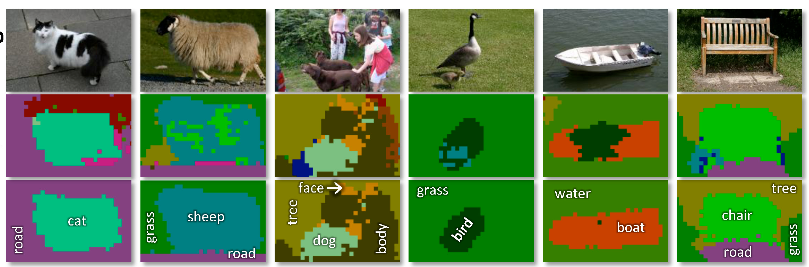
source: http://mi.eng.cam.ac.uk/~cipolla/publications/inproceedings/2008-CVPR-semantic-texton-forests.pdf
2. RandomForest-based methods

### Conv-based method:
1. patch-based classification
2. Fully Convolutional Networks (FCN)
3. Encoder-decoder: U-net (https://arxiv.org/pdf/1505.04597.pdf)
4. Dilated Convolutions
5. 

A nice review of each method can be found here:
http://blog.qure.ai/notes/semantic-segmentation-deep-learning-review#segnet

## U-Net structure

![grafik.png](u-net-architecture.png)
Source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

## Convolutional Neural Network

### 2D Conv
![grafik.png](An-example-of-convolution-operation-in-2D-2.png)
Source: https://www.researchgate.net/figure/An-example-of-convolution-operation-in-2D-2_fig3_324165524
### Pooling
![grafik.png](An-example-of-pooling-with-a-2-2-filter-and-a-stride-of-2.png)
Source: https://www.researchgate.net/figure/An-example-of-pooling-with-a-2-2-filter-and-a-stride-of-2_fig4_324165524
## Conv + Stride
![grafik.png](conv+stridding.png)
Source: https://www.slideshare.net/SangJunLee37/week-6-convolutional-neural-networks

## CNN with Keras

### Loading libraries

In [1]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
from keras.layers import Input
from keras import Model
import numpy as np
from keras import optimizers
from keras.models import load_model
from keras import backend as K
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Using TensorFlow backend.


### Prepare a function to introduce padding in the image:
for more info:
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.pad.html

In [2]:
def _padding_image(array_to_pad,padding_type):
    
    if padding_type is 'constant':
    
        padded_array =np.pad(array_to_pad, ((14,13),(14,13),(0,0)), 'constant',
                             constant_values=(0, 0))
    
    if padding_type is 'symmetric':
        padded_array =np.pad(array_to_pad, ((14,13),(14,13),(0,0)),
                             'symmetric')
    
    if 'wrap' in padding_type:
        padded_array =np.pad(array_to_pad, ((14,13),(14,13),(0,0)), 'wrap')
        
    if 'reflect' in padding_type:
        padded_array =np.pad(array_to_pad, ((14,13),(14,13),(0,0)), 'reflect')
        
    return padded_array

### Prepare a function to get the name of the images:

In [3]:
path_train = './data/images/'
path_train_mask = './data/masks/'

# read all the image file name from the folder
def _images_id(path):
    
    _ids = next(os.walk(path))[2]
    
    return _ids

train_ids = _images_id(path_train)

### Initiate variables

In [127]:
image_to_load = 50
X_train = np.zeros((image_to_load, 128, 128, 1), dtype=np.uint8)
Y_train = np.zeros((image_to_load,128, 128, 1), dtype=np.bool)

### Prepare a function to load images using Keras preprossing function

In [128]:
def _load_an_image(path,_id):
    
    loaded_image = load_img(path + _id)
    
    return loaded_image

### Prepare a function to convert the image to array for further processing

In [6]:
def _img_to_array(loaded_image):
    
    _array = img_to_array(loaded_image)[:,:,1:2]
    
    return _array

### Load images
Spicify the number of image that you want to load be modifying the variable 'n_image'

In [129]:
n_image = image_to_load
k = 0
padding = True
padding_type = 'reflect'
for train_id in train_ids:
    loaded_train_image = _load_an_image(path_train,train_id)
    loaded_train_mask = _load_an_image(path_train_mask,train_id)
    if padding:
        train_x = _img_to_array(loaded_train_image)
        train_y = _img_to_array(loaded_train_mask)
        X_train[k] = _padding_image(train_x,padding_type)
        Y_train[k] = _padding_image(train_y,padding_type)
    k +=1
    if k == n_image:
        break

### print a sample of the mask array

In [130]:
sample_nr = 25
print(Y_train[sample_nr,:,:,0].astype(int))

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


### Prepare a function to print both the train image and its mask

In [185]:
def plot_sample_image(X_train,Y_train,model,image_nr=0,prediction = False,threshold = 0.5):
    print(train_ids[image_nr])
    plt.figure(figsize=(10,5))
    subfig_nr = 2
    if prediction:
        subfig_nr = 3
        preds_train = np.zeros((X_train.shape))
        preds_train[image_nr] = model.predict(X_train[image_nr:image_nr+1])
        plt.subplot(1,subfig_nr,3)
        plt.imshow(preds_train[image_nr,:,:,0]> threshold)
        plt.title("predicted mask for image Nr.{}".format(image_nr))
        print("IoU = {} %".format(round(_calculate_scoring(Y_train[image_nr,:,:,0],
                                                     (preds_train[image_nr,:,:,0]> threshold).astype(int))*100)))
    plt.subplot(1,subfig_nr,1)
    plt.imshow(X_train[image_nr,:,:,0])
    plt.title("train image Nr.{}".format(image_nr))
    plt.subplot(1,subfig_nr,2)
    plt.imshow(Y_train[image_nr,:,:,0].astype(int))
    plt.title("mask for image Nr.{}".format(image_nr))
    plt.show()

In [186]:
def f1(x):
    plot_sample_image(X_train,Y_train,'',x)
    
interact(f1, x=widgets.IntSlider(min=0,max=image_to_load-1,step=1,value=0));


interactive(children=(IntSlider(value=0, description='x', max=49), Output()), _dom_classes=('widget-interact',))

### Load the trained model

In [22]:
model = load_model('./keras_random_state_0.model')

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 128, 128, 16) 64          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 128, 128, 16) 0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
conv2d_48 

In [120]:
print("there are {} layers".format(len(model.layers)))

there are 176 layers


### Print the prediction
Define the score

In [165]:
def _calculate_scoring(sample_x,sample_pre_x):
    TP = np.sum(1*np.subtract(sample_x,sample_pre_x)==0)
    FP = np.sum(1*np.subtract(sample_x,sample_pre_x)<0)
    FN = np.sum(1*np.subtract(sample_x,sample_pre_x)>0)
    if (TP+FP+FN)!=0:
        IoU_t = TP/(TP+FP+FN)
    else:
        IoU_t = 0
        
    return IoU_t

In [184]:
def f2(x,y):
    print("x is the number of the image")
    print("y is the threshold in %")
    plot_sample_image(X_train,Y_train,model,x,True,threshold=y/100)

interact(f2, x=widgets.IntSlider(min=0,max=image_to_load-1,step=1,value=16),
         y=widgets.IntSlider(min=0,max=95,step=1,value=50));

interactive(children=(IntSlider(value=16, description='x', max=49), IntSlider(value=50, description='y', max=95), Output()), _dom_classes=('widget-interact',))

### Print filter

In [44]:
def print_filter(layer_nr,filter_nr):
    try:
        print("Layer {}".format(model.layers[layer_nr]))
        W = model.layers[layer_nr].get_weights()[0]
        print("W shape : ", W.shape)
        if len(W.shape) == 4:
        #W = np.squeeze(W)
            W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
            print(W[:,:,filter_nr])
            fig = plt.figure()
            fig.subplots_adjust(hspace = .5, wspace=.001)
            im = plt.imshow(W[:,:,filter_nr])
            plt.title("layer: {}, filter nr. {}".format(layer_nr, filter_nr))
            fig.colorbar(im)
        plt.show()
    except:
        print("No (more) fitlers is this layer")

In [45]:
def f4(x,y):
    print("x: the layer nr. {}".format(x))
    print("y: the filter nr. {}".format(y))
    print_filter(x,y)

interact(f4, x=widgets.IntSlider(min=0,max=50,step=1,value=0),y=widgets.IntSlider(min=0,max=200,step=1,value=0));

interactive(children=(IntSlider(value=0, description='x', max=50), IntSlider(value=0, description='y', max=200), Output()), _dom_classes=('widget-interact',))

### Print result of image after each layer

In [91]:
inputs = [K.learning_phase()] + model.inputs

In [113]:
def layer_output(image_nr, layer_nr):
    print(model.layers[layer_nr])
    _convout1_f = K.function(inputs, [model.layers[layer_nr].output])
    def convout1_f(X):
    # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])
    output_image = convout1_f(X_train[image_nr:image_nr+1])
    output_image = np.squeeze(output_image)
    return output_image

In [124]:
def plot_layer_image(X_train,Y_train,output_image,channel_i,image_nr=0):
    plt.figure(figsize=(10,5))
    subfig_nr = 3
    plt.subplot(1,subfig_nr,3)
    try:
        plt.imshow(output_image[:,:,channel_i])
    except:
        plt.imshow(output_image[:,:])
    plt.title(" image in channel Nr.{}".format(channel_i))
    plt.subplot(1,subfig_nr,1)
    plt.imshow(X_train[image_nr,:,:,0])
    plt.title("train image Nr.{}".format(image_nr))
    plt.subplot(1,subfig_nr,2)
    plt.imshow(Y_train[image_nr,:,:,0].astype(int))
    plt.title("mask for image Nr.{}".format(image_nr))
    plt.show()

In [173]:
def f4(x,y,z):
    print("x: the image nr. {}".format(x))
    print("y: the layer nr. {}".format(y))
    print("z: the channel nr. {}".format(z))
    try:
        output_image = layer_output(x,y)
        print(output_image.shape)
        plot_layer_image(X_train,Y_train,output_image,channel_i=z,image_nr=x)
    except:
        print("Nothing to show")

interact(f4, x=widgets.IntSlider(min=0,max=image_to_load-1,step=1,value=16),
            y=widgets.IntSlider(min=0,max=200,step=1,value=175),
            z=widgets.IntSlider(min=0,max=200,step=1,value=0));

interactive(children=(IntSlider(value=16, description='x', max=49), IntSlider(value=175, description='y', max=200), IntSlider(value=0, description='z', max=200), Output()), _dom_classes=('widget-interact',))

## References:

https://github.com/philipperemy/keras-activations

https://www.ir.com/blog/visualizing-outputs-cnn-model-training-phase

https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

https://www.analyticsvidhya.com/blog/2018/03/essentials-of-deep-learning-visualizing-convolutional-neural-networks/

https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

https://github.com/keras-team/keras/issues/8772

https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/

https://towardsdatascience.com/deep-learning-tips-and-tricks-1ef708ec5f53

https://fairyonice.github.io/Visualization%20of%20Filters%20with%20Keras.html

http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

http://crcv.ucf.edu/courses/CAP6412/Spring2018/KerasTutorial.pdf